2024-11-09 20:45:23.775 Python[33033:2551671] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-09 20:45:23.776 Python[33033:2551671] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/var/folders/mt/kj19hc1n2tj2wnz01n8plf1h0000gn/T/ipykernel_33033/761739765.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'].str.replace('\u202f', '', regex=False), errors='coerce')


KeyboardInterrupt: 

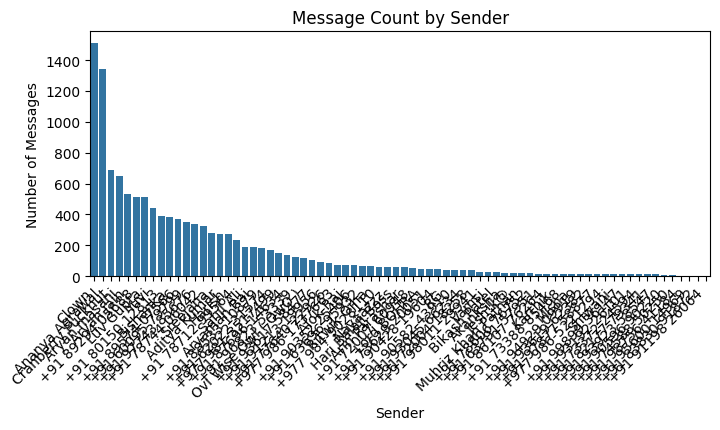

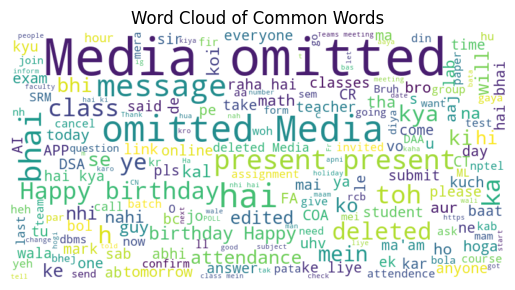

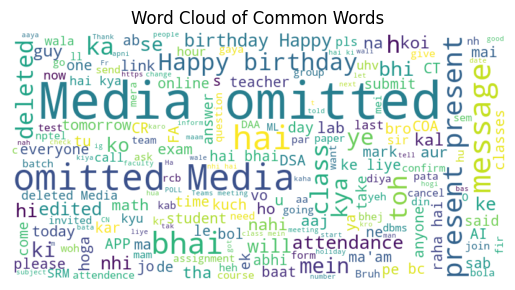

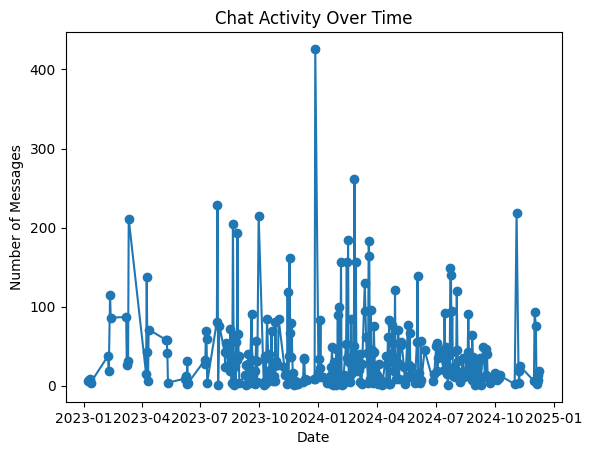

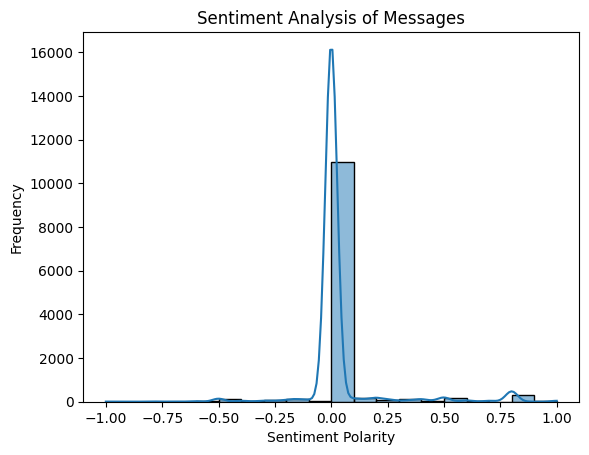

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from collections import Counter
from urlextract import URLExtract
from urllib.parse import urlparse
from wordcloud import WordCloud
from textblob import TextBlob
import tkinter as tk
from tkinter import filedialog, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Initialize Tkinter
root = tk.Tk()
root.title("WhatsApp Chat Analyzer")
root.geometry("800x600")

# Global variable for DataFrame
df = None

# Function to load chat file
def load_chat():
    global df
    filepath = filedialog.askopenfilename(title="Open Chat File", filetypes=[("Text Files", "*.txt")])
    if not filepath:
        return

    try:
        # Read and parse chat data
        with open(filepath, 'r', encoding='utf-8') as f:
            data = f.read()

        # Regular expression pattern for extracting messages
        pattern = r'(\d+/\d+/\d+, \d+:\d+\s*[ap]m) - ([^:]+): (.*)'
        matches = re.findall(pattern, data)

        # Extract data into lists
        timestamps, senders, messages = zip(*matches)

        # Create a DataFrame
        df = pd.DataFrame({"timestamp": timestamps, "sender": senders, "message": messages})

        # Clean and convert timestamp column
        df['timestamp'] = pd.to_datetime(df['timestamp'].str.replace('\u202f', '', regex=False), errors='coerce')
        messagebox.showinfo("Success", "Chat file loaded successfully!")
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load chat file: {e}")

# Function to display message count per sender
def show_sender_message_count():
    global df
    if df is None:
        messagebox.showerror("Error", "Please load a chat file first.")
        return

    sender_count = df["sender"].value_counts()
    fig, ax = plt.subplots()
    sns.barplot(x=sender_count.index, y=sender_count.values, ax=ax)
    ax.set_title("Message Count by Sender")
    ax.set_xlabel("Sender")
    ax.set_ylabel("Number of Messages")
    fig.autofmt_xdate(rotation=45)

    display_plot(fig)

# Function to display word cloud
def show_wordcloud():
    global df
    if df is None:
        messagebox.showerror("Error", "Please load a chat file first.")
        return

    # Combine all messages and generate word cloud
    text = " ".join(df['message'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(WordCloud().stopwords)).generate(text)

    fig, ax = plt.subplots()
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title("Word Cloud of Common Words")

    display_plot(fig)

# Function to display chat activity over time
def show_chat_activity():
    global df
    if df is None:
        messagebox.showerror("Error", "Please load a chat file first.")
        return

    # Extract day and hour
    df['date'] = df['timestamp'].dt.date
    activity = df['date'].value_counts().sort_index()

    fig, ax = plt.subplots()
    ax.plot(activity.index, activity.values, marker='o')
    ax.set_title("Chat Activity Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Messages")

    display_plot(fig)

# Function to perform sentiment analysis
def show_sentiment_analysis():
    global df
    if df is None:
        messagebox.showerror("Error", "Please load a chat file first.")
        return

    # Analyze sentiment
    sentiments = df['message'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment'] = sentiments

    # Plot sentiment
    fig, ax = plt.subplots()
    sns.histplot(df['sentiment'], bins=20, kde=True, ax=ax)
    ax.set_title("Sentiment Analysis of Messages")
    ax.set_xlabel("Sentiment Polarity")
    ax.set_ylabel("Frequency")

    display_plot(fig)

# Helper function to display matplotlib plots in Tkinter
def display_plot(fig):
    for widget in root.winfo_children():
        if isinstance(widget, FigureCanvasTkAgg):
            widget.get_tk_widget().destroy()

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# UI Elements
load_button = tk.Button(root, text="Load Chat File", command=load_chat)
load_button.pack(pady=10)

sender_button = tk.Button(root, text="Show Sender Message Count", command=show_sender_message_count)
sender_button.pack(pady=10)

wordcloud_button = tk.Button(root, text="Show Word Cloud", command=show_wordcloud)
wordcloud_button.pack(pady=10)

activity_button = tk.Button(root, text="Show Chat Activity Over Time", command=show_chat_activity)
activity_button.pack(pady=10)

sentiment_button = tk.Button(root, text="Show Sentiment Analysis", command=show_sentiment_analysis)
sentiment_button.pack(pady=10)

root.mainloop()
